### 0.87089 ROC-AUC 
score on https://www.kaggle.com/competitions/playground-series-s5e3/overview

```catboost(fine tuning)```

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [119]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [120]:
train_data.head()
# Change maxtemp, mintemp and temperature colummns to one

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [121]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


<Axes: >

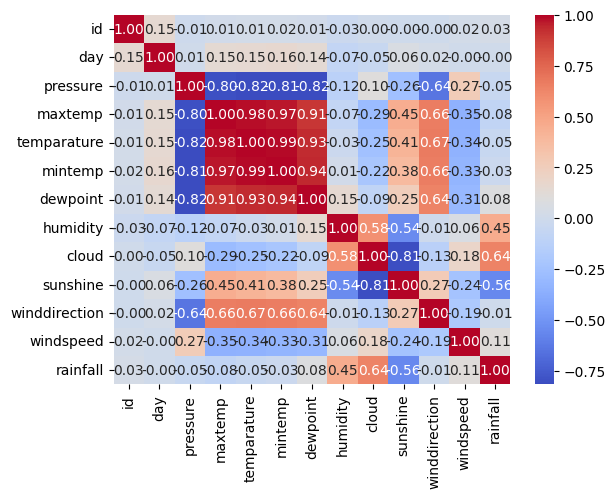

In [122]:
sns.heatmap(train_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')

In [123]:
class Preproccessing:
    def __init__(self, data):
        self.data = data

    def transform(self, columns_to_drop=None) -> pd.DataFrame:
        self.data["temp_diff"] = self.data["maxtemp"] - self.data["mintemp"]

        if columns_to_drop:
            self.data = self.data.drop(columns=columns_to_drop, axis=1)

        return self.data


In [124]:
train_data = Preproccessing(train_data).transform(columns_to_drop=["maxtemp", "mintemp", "dewpoint", "id", "day"])

In [125]:
train_data.head()

,pressure,temparature,humidity,cloud,sunshine,winddirection,windspeed,rainfall,temp_diff
0,1017.4,20.6,87.0,88.0,1.1,60.0,17.2,1,1.3
1,1019.5,16.9,95.0,91.0,0.0,50.0,21.9,1,0.4
2,1024.1,16.1,75.0,47.0,8.3,70.0,18.1,1,4.8
3,1013.4,17.8,95.0,95.0,0.0,60.0,35.6,1,1.2
4,1021.8,18.4,52.0,45.0,3.6,40.0,24.8,0,6.1


<Axes: >

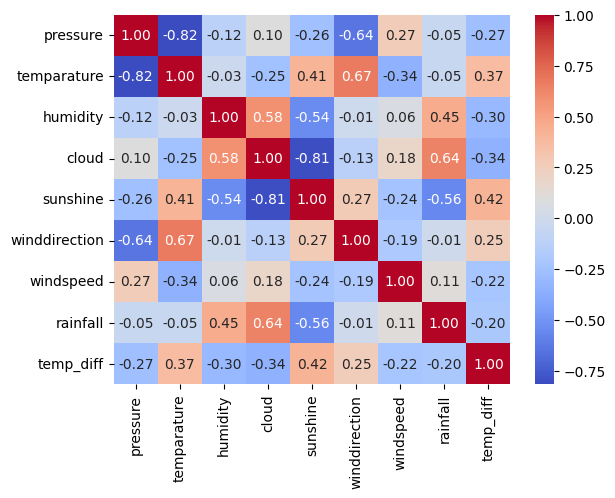

In [126]:
sns.heatmap(train_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')

(array([ 540.,    0., 1650.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

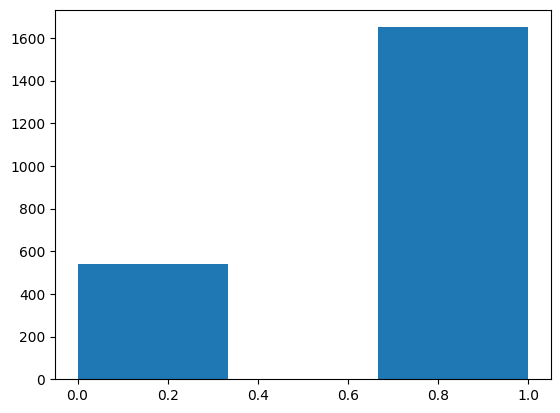

In [127]:
#check target distribution
plt.hist(train_data['rainfall'], bins=3)

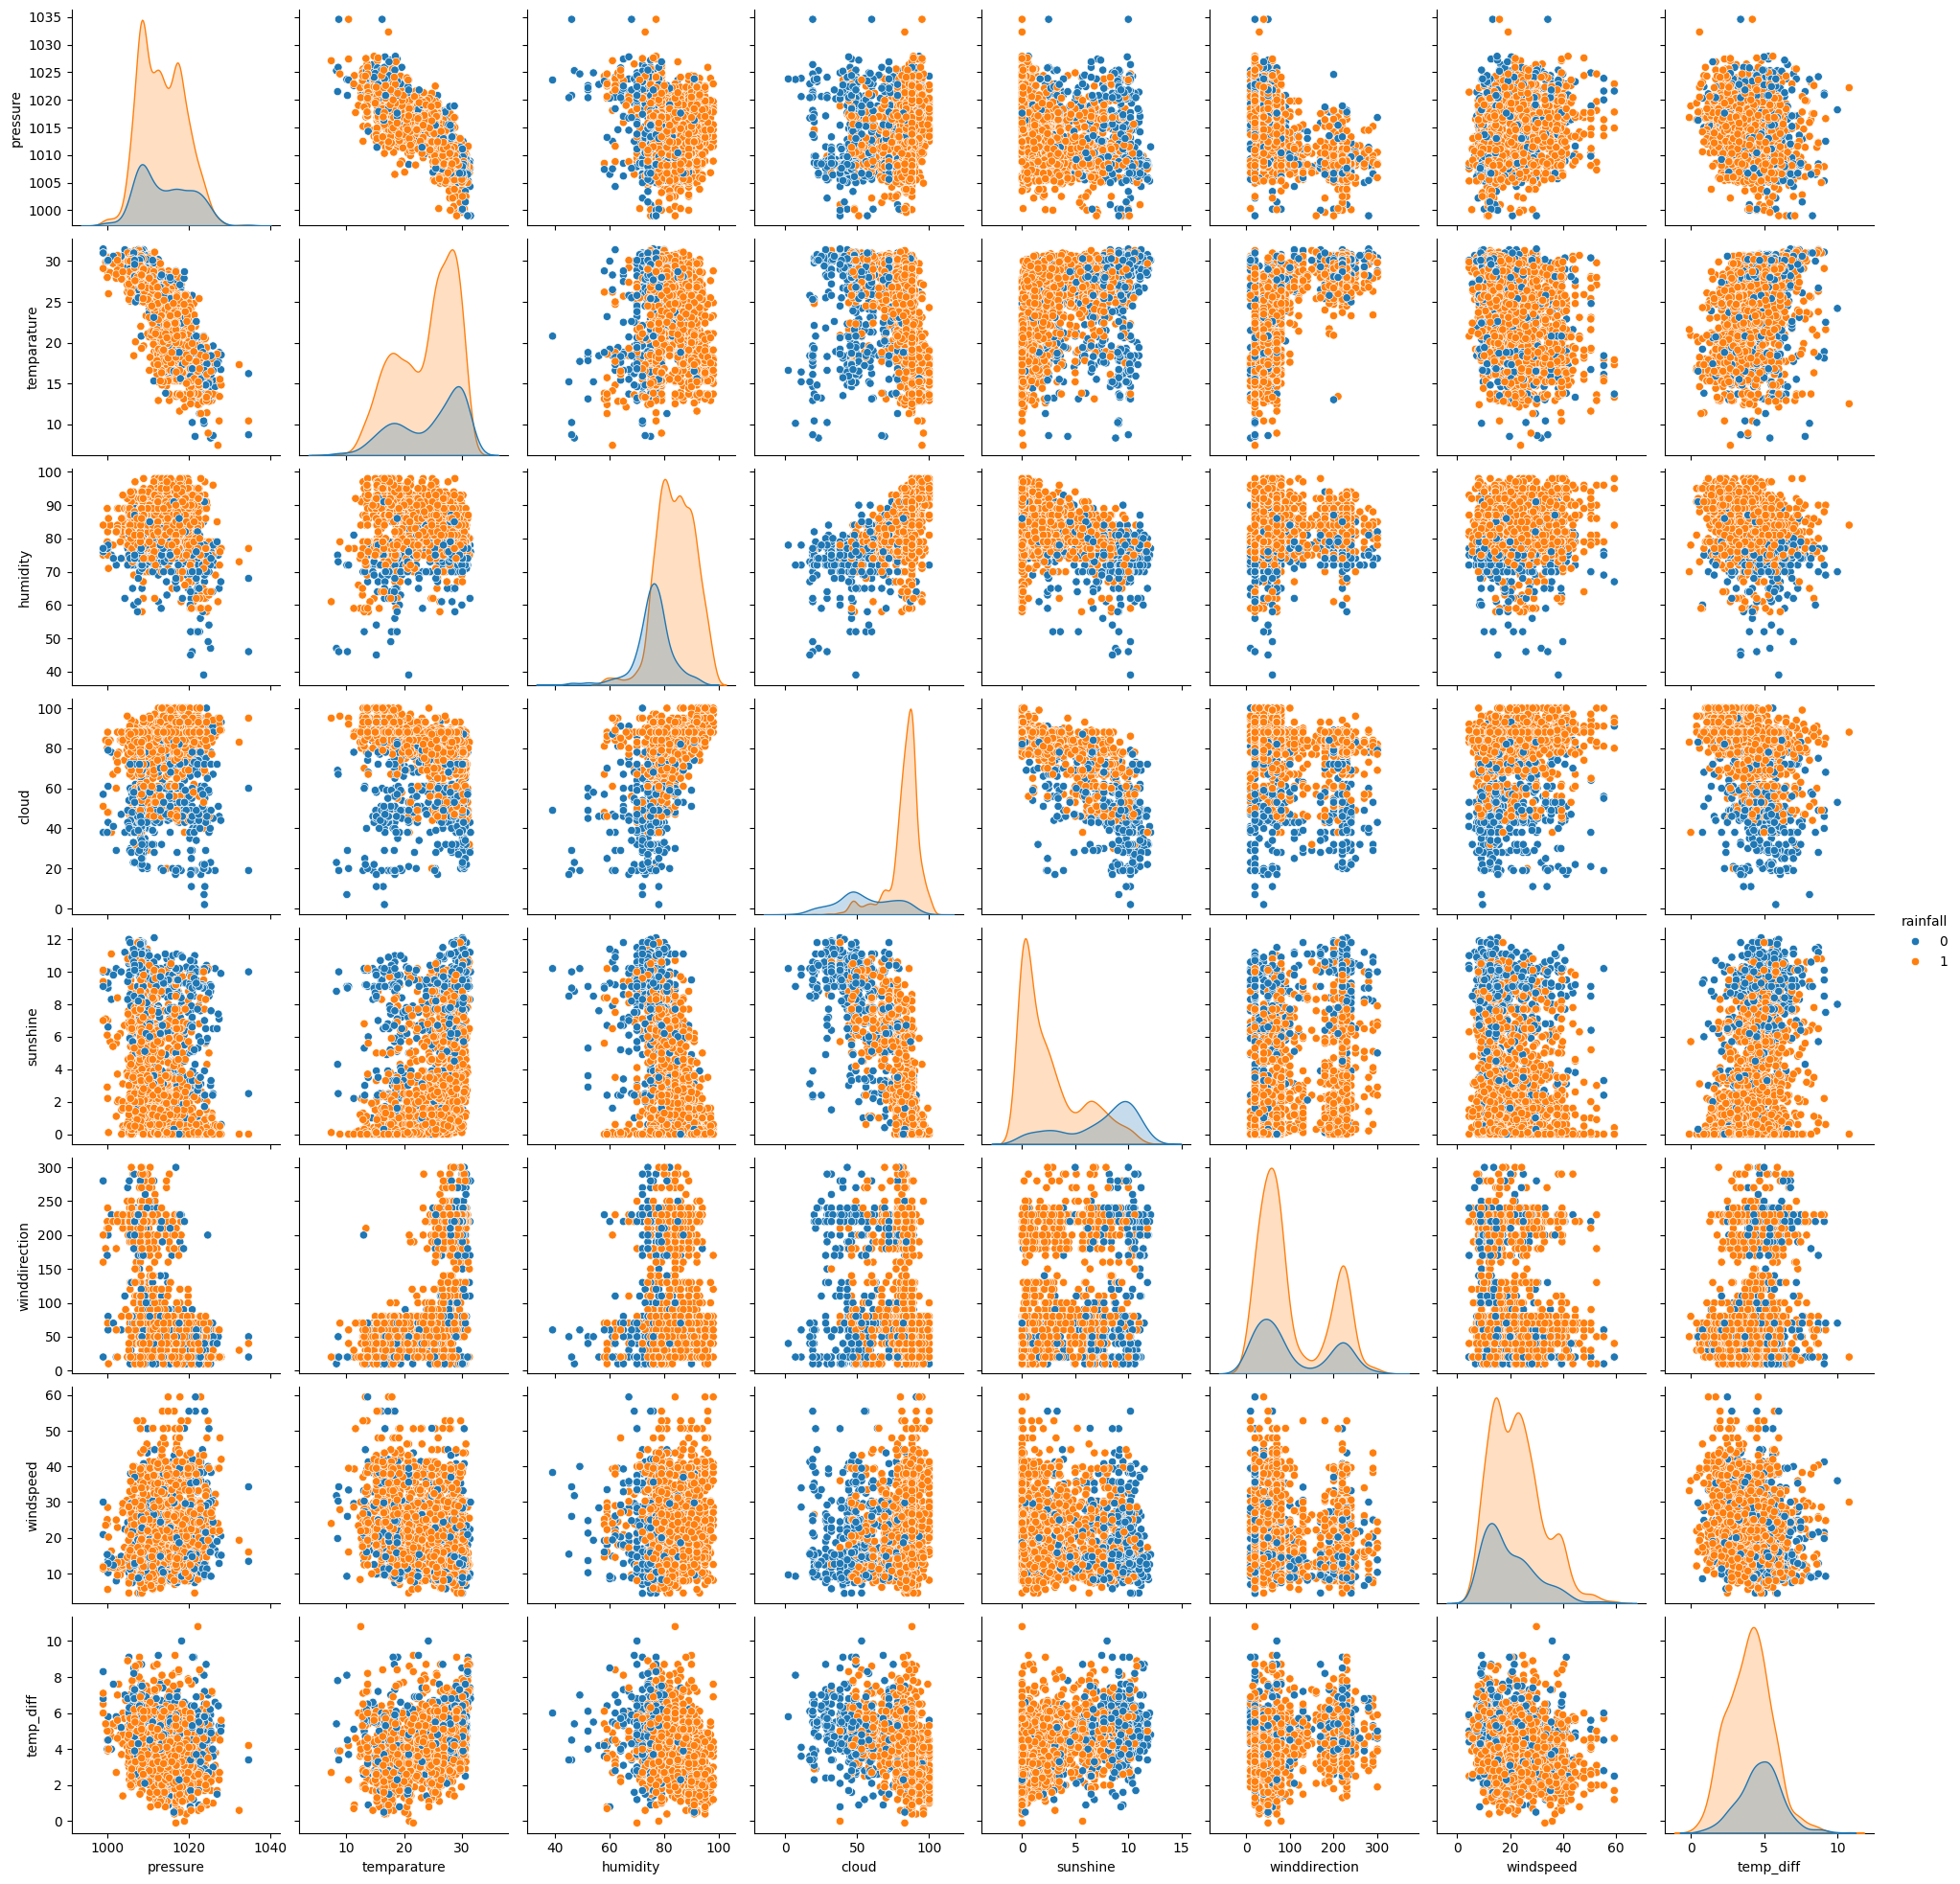

In [128]:
sns.pairplot(train_data, hue="rainfall")

Target distributed unevenly, there are not uniform distribution, no linear dependencies

['pressure' 'temparature' 'humidity' 'cloud' 'sunshine' 'winddirection'
 'windspeed' 'rainfall' 'temp_diff']


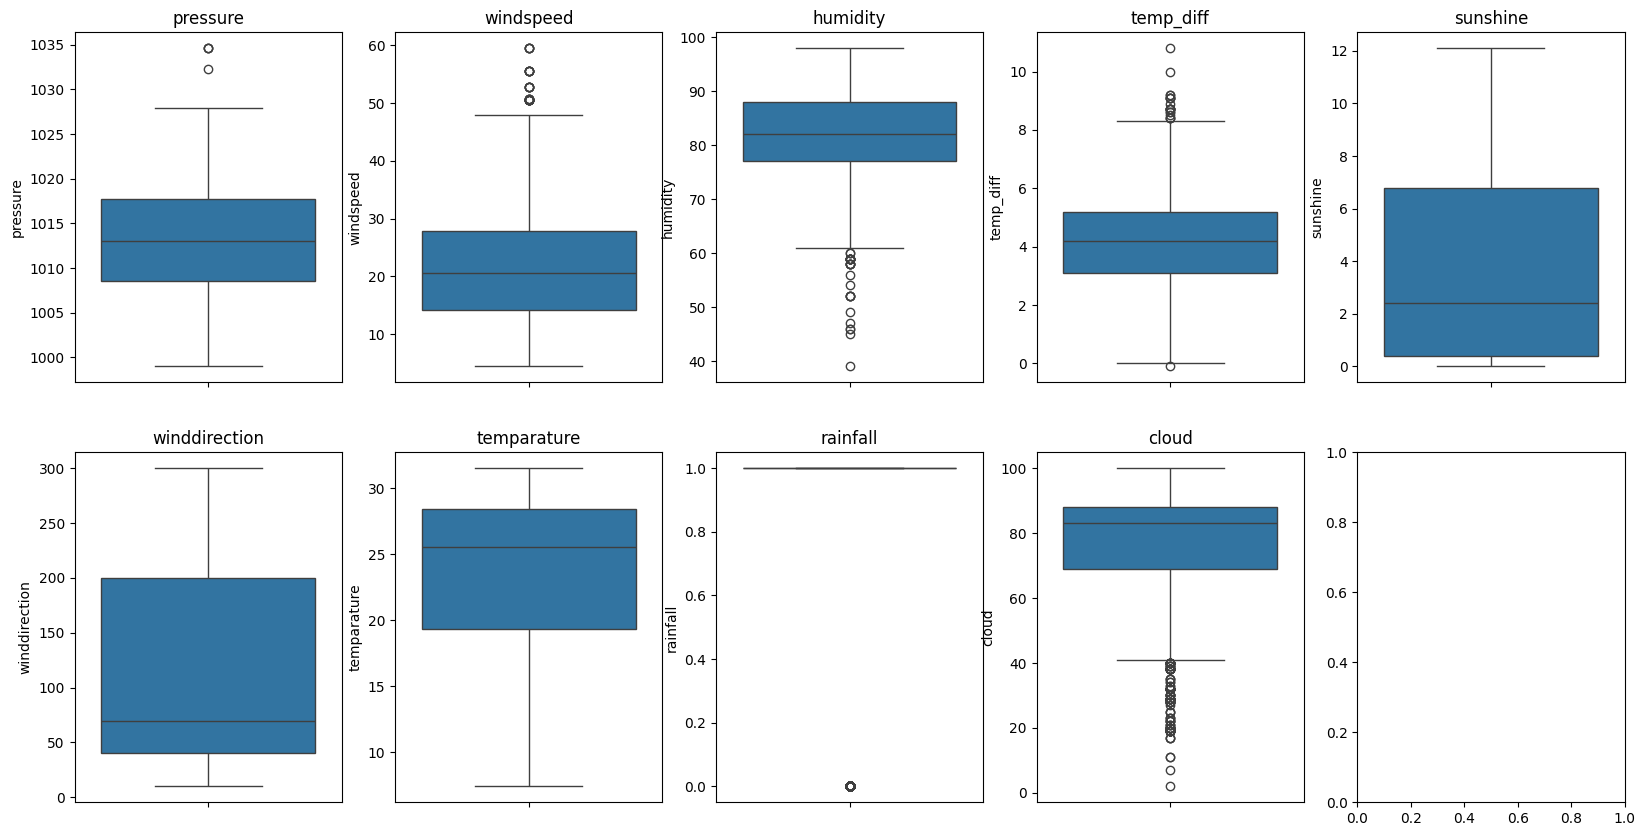

In [129]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

columns = train_data.columns.values
print(columns)
for i in range(9):
    sns.boxplot(train_data[columns[i]], ax=axs[i%2, i%5])
    axs[i%2, i%5].set_title(columns[i])
plt.show()

Columns with emissions: cloud, pressure, windspeed, humidity, temp_dif

In [136]:
# train_data.loc[train_data.pressure > 1030, "pressure"] = train_data.loc[train_data.pressure > 1030, "pressure"].(train_data.pressure.mean())
train_data.loc[train_data.pressure > 1030, "pressure"] = train_data.pressure.mean()
train_data.loc[train_data.cloud < 20, "cloud"] = train_data.cloud.mean()
train_data.loc[train_data.windspeed > 47, "windspeed"] = train_data.windspeed.mean()
train_data.loc[train_data.humidity < 63, "humidity"] = train_data.humidity.mean()
train_data.loc[train_data.temp_diff > 8, "temp_diff"] = train_data.temp_diff.mean()
train_data.loc[train_data.temp_diff < 0.5, "temp_diff"] = train_data.temp_diff.mean()

['pressure' 'temparature' 'humidity' 'cloud' 'sunshine' 'winddirection'
 'windspeed' 'rainfall' 'temp_diff']


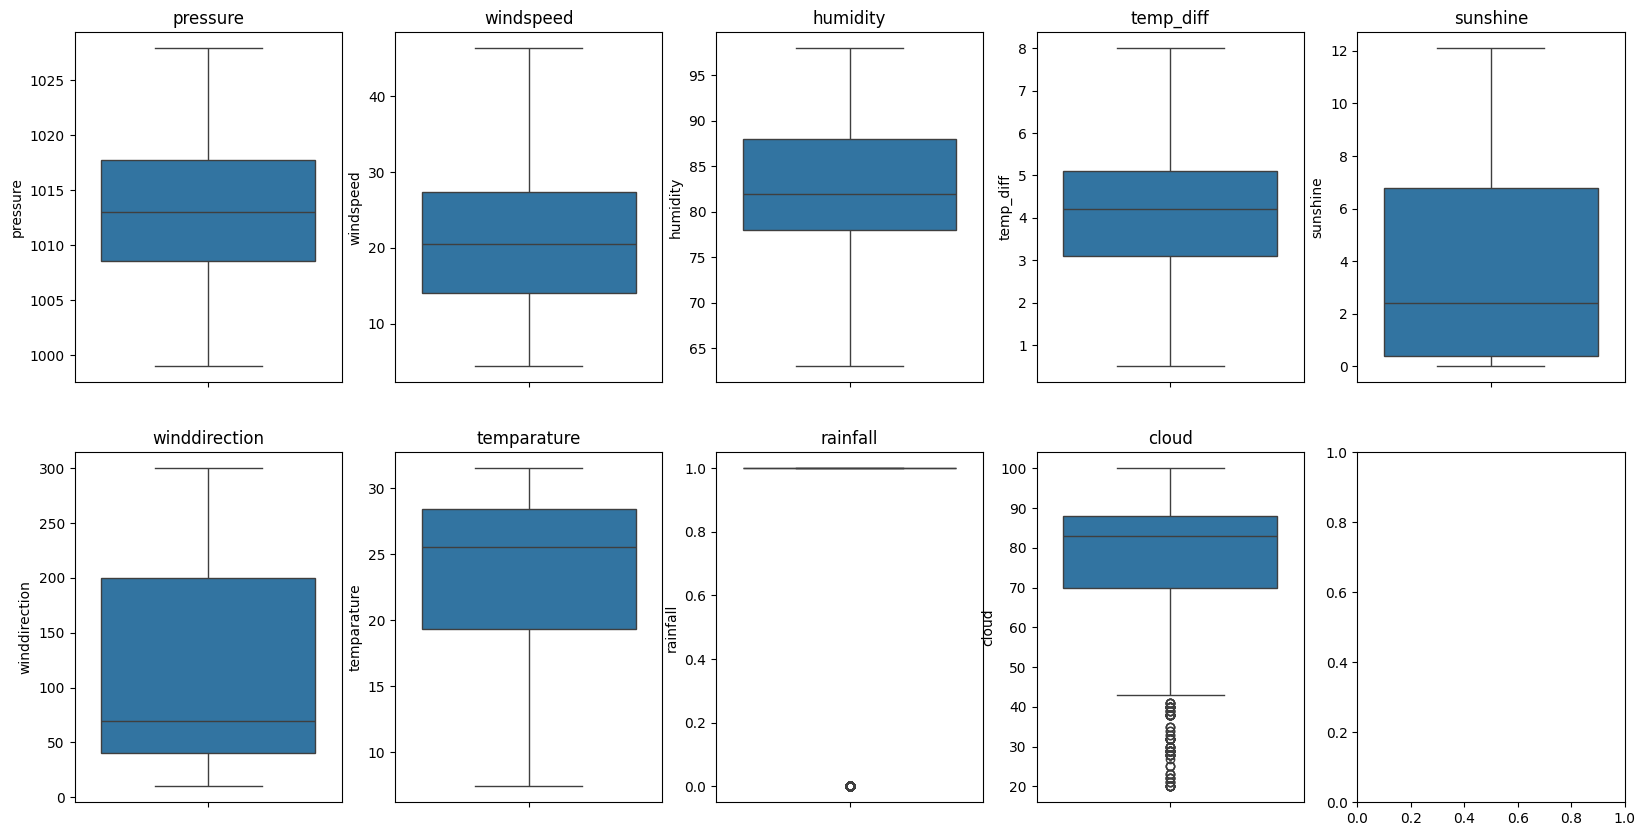

In [137]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

columns = train_data.columns.values
print(columns)
for i in range(9):
    sns.boxplot(train_data[columns[i]], ax=axs[i%2, i%5])
    axs[i%2, i%5].set_title(columns[i])
plt.show()

In [175]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score


In [ ]:
test_data = Preproccessing(test_data).transform(columns_to_drop=["maxtemp", "mintemp", "dewpoint", "id", "day"])

In [192]:
from collections import Counter

counts = Counter(train_data['rainfall'])
majority = max(counts.values())
weights = [majority / counts[c] for c in sorted(counts)]
weights

[3.0555555555555554, 1.0]

In [196]:
catboost = CatBoostClassifier(iterations=1000, loss_function='Logloss', verbose=0, class_weights=weights, random_seed=42)

In [197]:
params = {
    'learning_rate': [1e-2, 1e-1, 0.3],
    'depth': np.linspace(5, 9, 5, dtype=int),
    'l2_leaf_reg': [1e-1, 1, 10]
}

In [198]:
catboost.grid_search(
    param_grid=params,
    X=train_data.drop(columns=['rainfall']),
    y=train_data['rainfall'],
    cv=5,
    plot=True,
    verbose=False,
    train_size=0.8
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4107642805
bestIteration = 423


bestTest = 0.4024621707
bestIteration = 65


bestTest = 0.4200333539
bestIteration = 8


bestTest = 0.4097099163
bestIteration = 533


bestTest = 0.4059078687
bestIteration = 64


bestTest = 0.4104790056
bestIteration = 8


bestTest = 0.4080643552
bestIteration = 673


bestTest = 0.4024510626
bestIteration = 49


bestTest = 0.4117065049
bestIteration = 19


bestTest = 0.4093129361
bestIteration = 361


bestTest = 0.428346733
bestIteration = 24


bestTest = 0.4468302523
bestIteration = 4


bestTest = 0.405900204
bestIteration = 447


bestTest = 0.4194954787
bestIteration = 30


bestTest = 0.4282294363
bestIteration = 14


bestTest = 0.4079827572
bestIteration = 617


bestTest = 0.4092678942
bestIteration = 38


bestTest = 0.419879671
bestIteration = 14


bestTest = 0.4161456737
bestIteration = 268


bestTest = 0.4411093628
bestIteration = 28


bestTest = 0.4885514688
bestIteration = 6


bestTest = 0.4092649016
bestIteration = 305


bestTest

{'params': {'depth': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 10},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [199]:
catboost.fit(train_data.drop(columns=['rainfall']), train_data['rainfall'], verbose=0)

In [200]:
preds = catboost.predict(train_data.drop(columns=['rainfall']))

In [201]:
score = roc_auc_score(train_data['rainfall'], preds)

In [202]:
score

0.996969696969697

In [203]:
prediction = catboost.predict_proba(test_data)

In [204]:
my_submission = pd.read_csv('data/sample_submission.csv')
my_submission.rainfall = prediction[:, 1]
my_submission.to_csv('data/submission.csv', index=False)